# Preparing
Run once when disconnected

In [ ]:
# imports
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GaussianNoise, BatchNormalization
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import zipfile
from sklearn.metrics import f1_score
import os
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
# # download the dataset
# if (not os.path.isfile('x.npy')):
#     !wget -q https://gist.github.com/kezzyhko/74136f15acb0ac57e64a761176776ab0/raw/x.npy
# if (not os.path.isfile('y.npy')):
#     !wget -q https://gist.github.com/kezzyhko/74136f15acb0ac57e64a761176776ab0/raw/y.npy

In [ ]:
# load the dataset

(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()
mnist_X_train = mnist_X_train.reshape((60000, 28, 28, 1))
mnist_X_test = mnist_X_test.reshape((10000, 28, 28, 1))

x = np.concatenate((mnist_X_train, mnist_X_test), axis=0)
y = np.concatenate((mnist_y_train, mnist_y_test), axis=0)

print(x.shape)
print(y.shape)

(70000, 28, 28, 1)
(70000,)


# Data augmentation

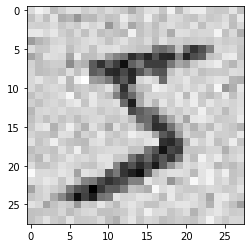

In [ ]:
# plt.imshow(x[0].reshape(28, 28)/255., cmap='Greys')
g = GaussianNoise(40)
x = g(x.astype('float32'), training=True)
plt.imshow(tf.reshape(x[0], (28, 28))/255., cmap='Greys')

In [ ]:
generator = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.3,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    validation_split = 0.15
)

# The model

## Make the model

In [ ]:
# create the model

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides = 2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides = 2))

model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=[Recall(), Precision()])

In [ ]:
# train the model
# model.fit(x, to_categorical(y), validation_split=0.15)
model.fit(
    generator.flow(x, to_categorical(y), batch_size = 128),
    validation_data = generator.flow(x, to_categorical(y), batch_size = 128, subset = 'validation'),
    steps_per_epoch = len(x) / 128,
    epochs = 10
)

Epoch 1/10
547/546 [==============================] - 24s 43ms/step - loss: 0.4012 - recall_11: 0.8278 - precision_11: 0.9386 - val_loss: 0.1294 - val_recall_11: 0.9575 - val_precision_11: 0.9683
Epoch 2/10
547/546 [==============================] - 23s 42ms/step - loss: 0.0926 - recall_11: 0.9676 - precision_11: 0.9760 - val_loss: 0.0634 - val_recall_11: 0.9777 - val_precision_11: 0.9833
Epoch 3/10
547/546 [==============================] - 23s 42ms/step - loss: 0.0668 - recall_11: 0.9770 - precision_11: 0.9828 - val_loss: 0.0550 - val_recall_11: 0.9804 - val_precision_11: 0.9845
Epoch 4/10
547/546 [==============================] - 23s 42ms/step - loss: 0.0564 - recall_11: 0.9807 - precision_11: 0.9852 - val_loss: 0.0622 - val_recall_11: 0.9778 - val_precision_11: 0.9828
Epoch 5/10
547/546 [==============================] - 23s 42ms/step - loss: 0.0467 - recall_11: 0.9836 - precision_11: 0.9874 - val_loss: 0.0504 - val_recall_11: 0.9827 - val_precision_11: 0.9862
Epoch 6/10
547/546 [

## Save the model

In [ ]:
# save the model
model.save('model.h5')
zipfile.ZipFile('model.h5.zip', mode='w').write("model.h5")
print(os.path.getsize("/content/model.h5.zip") / (1024*1024))
files.download('model.h5.zip') 

71.96560096740723


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation

In [ ]:
# make the prediction
y_pred = model.predict(x)

In [ ]:
# transform prediction to labels
y_pred_labels = np.argmax(y_pred, axis=1).astype(np.uint8)

In [ ]:
# evaluate performance of the model
tf.print(f1_score(y_pred_labels, y, average='micro'))
tf.print(f1_score(y_pred_labels, y, average='macro'))
tf.print(f1_score(y_pred_labels, y, average='weighted'))

0.9953571428571428
0.9953461024062745
0.9953565737331785
